Covariance matrix of whitened data
[[ 1. -0.]
 [-0.  1.]]
Extracting signal 0 finished for iter: 2 with dot(wNew, w) product: 0.9999999997422937
Extracting signal 1 finished for iter: 2 with dot(wNew, w) product: -1.0


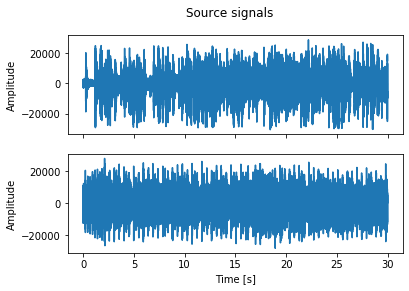

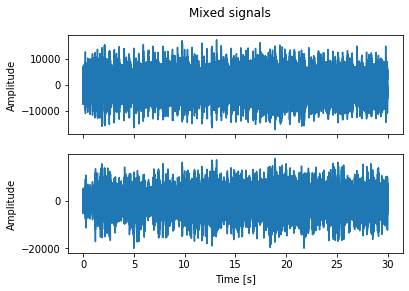

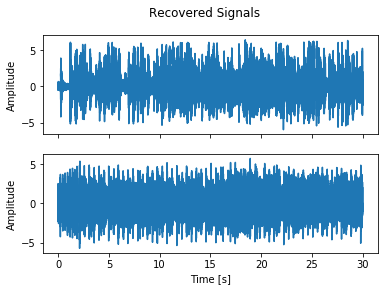

FastICA has been successfully applied to mixed signals.
Results have been writen to path './data/mono/example_with_II_signals/'.


In [1]:
import numpy as np
from scipy.io import wavfile

import matplotlib.pyplot as plt
import glob
 
def center(x):
    mean = x.mean(axis=1, keepdims=True)
    x_centered = x - mean
    return x_centered
 
def compute_covariance(x):
    x_centered = center(x)
    cov = np.dot(x_centered, x_centered.T)/(x.shape[1] - 1)
    return cov
 
def whiten(x):
    # Calculate the covariance matrix
    covariance = compute_covariance(x)
 
    # Eigendecomposition
    eigen_values, eigen_vectors = np.linalg.eigh(covariance)
    # Compute whitening matrix for Principal Component Analysis (PCA)
    W_PCA = np.dot(np.diag(eigen_values**(-1/2)), eigen_vectors.T)
    X_whiten = np.dot(W_PCA, x)
    
    return X_whiten 

def estimate_contrast_functions(u):
    g = 1.0 / 4.0 * u**4
    g_derivative = u**3

    return g, g_derivative

def fastIca(signals, alpha = 1, threshold=1e-8, nb_iter=1000):
    n = len(signals)
    # Initialize random weights
    W = np.random.rand(n, n)
    for k, signal in enumerate(signals):
            w = W[k, :]
            w = w / np.sqrt((w ** 2).sum())
            i = 0
            while True:
                g, g_prim = estimate_contrast_functions(np.dot(w.T, signals))
                # Compute new weights
                wNew = np.mean(signals * g, axis=1) - np.mean(g_prim) * w
 
                # Decorrelate weights
                wNew = wNew - np.dot(np.dot(wNew, W[:k].T), W[:k])
                wNew = wNew / np.sqrt((wNew ** 2).sum())
                
                # Compute convergence condition
                manhattan_dist = np.abs(np.abs((wNew * w).sum()) - 1)
                w_dot_product = np.dot(wNew.T, w)
                
                # Update weights
                w = wNew
                i += 1
                
                # Check if algorithm converges
                if manhattan_dist <= threshold or i > nb_iter:
                    print(f"Extracting signal {k} finished for iter: {i} with dot(wNew, w) product: {w_dot_product}")
                    break
            W[k, :] = w.T
    return W
 
 
def plot_signals(signals, title="Source signals"):
    n = signals.shape[1]
    fig, axs = plt.subplots(n, 1)
    for i, signal in enumerate(signals.T):
        nb_samples = len(signal)
        t = np.linspace(0, 30, nb_samples)
        axs[i].plot(t, signal)
 
    for ax in axs.flat:
        ax.set(xlabel='Time [s]', ylabel='Amplitude')
 
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
 
    fig.suptitle(title)
    plt.show()
 
def convert_to_32bit(signal):
    m = np.max(np.abs(signalA))
    return (signal/m).astype(np.float32)
 
sample_rate, signalA = wavfile.read(f"./data/mono/example_with_II_signals/Elvis_30s.wav")
sample_rateB, signalB = wavfile.read(f"./data/mono/example_with_II_signals/GunsRoses.wav")

# Source matrix
S = np.array([signalA, signalB]).T

# Mixing matrix
A = np.array([[0.2, 0.5],
              [0.6, 0.4]])
 
# Mixed signal matrix
X = np.dot(S, A).T
 
# Center signals
Xc = center(X)
 
# Whiten mixed signals
Xw = whiten(Xc)
 
# Check if covariance of whitened matrix equals identity matrix
print("Covariance matrix of whitened data")
print(np.round(compute_covariance(Xw)))

W = fastIca(Xw,  alpha=1)
 
#Un-mix signals using
unMixed = Xw.T.dot(W.T)

plot_signals(S, title="Source signals")
plot_signals(X.T, title="Mixed signals")
plot_signals(unMixed, title="Recovered Signals")

wavfile.write("./data/mono/example_with_II_signals/initial_signalA.wav", sample_rate, convert_to_32bit(signalA))
wavfile.write("./data/mono/example_with_II_signals/initial_signalB.wav", sample_rate, convert_to_32bit(signalB))
wavfile.write("./data/mono/example_with_II_signals/mixed_signalA.wav", sample_rate,  convert_to_32bit(X[0, :]))
wavfile.write("./data/mono/example_with_II_signals/mixed_signalB.wav", sample_rate,  convert_to_32bit(X[1, :]))
wavfile.write("./data/mono/example_with_II_signals/unMixedA.wav", sample_rate, unMixed[:, 0].astype(np.float32))
wavfile.write("./data/mono/example_with_II_signals/unMixedB.wav", sample_rate, unMixed[:, 1].astype(np.float32))

print("FastICA has been successfully applied to mixed signals.")
print("Results have been writen to path './data/mono/example_with_II_signals/'.")

# Plot source signals with histograms

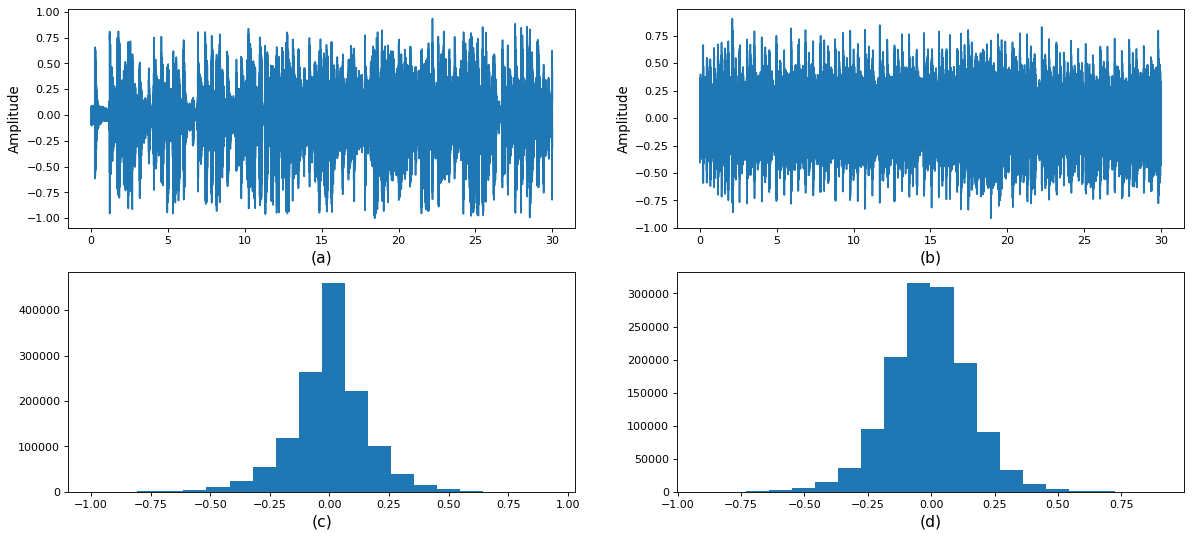

In [2]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

sample_rateA, signalA = wavfile.read("./data/mono/example_with_II_signals/initial_signalA.wav")
sample_rateB, signalB = wavfile.read("./data/mono/example_with_II_signals/initial_signalB.wav")
fig, axs = plt.subplots(2, 2, figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
tA = np.linspace(0, 30, len(signalA))
tB = np.linspace(0, 30, len(signalB))
axs[0][0].plot(tA, signalA)
axs[0][0].set_xlabel('(a)', fontsize=14)
axs[0][0].set_ylabel('Amplitude', fontsize=12)
axs[0][1].plot(tB, signalB)
axs[0][1].set_xlabel('(b)', fontsize=14)
axs[0][1].set_ylabel('Amplitude', fontsize=12)
axs[1][0].hist(signalA, bins=20)
axs[1][0].set_xlabel('(c)', fontsize=14)
axs[1][1].hist(signalB, bins=20)
axs[1][1].set_xlabel('(d)', fontsize=14)

plt.show()

# Plot mixed signals

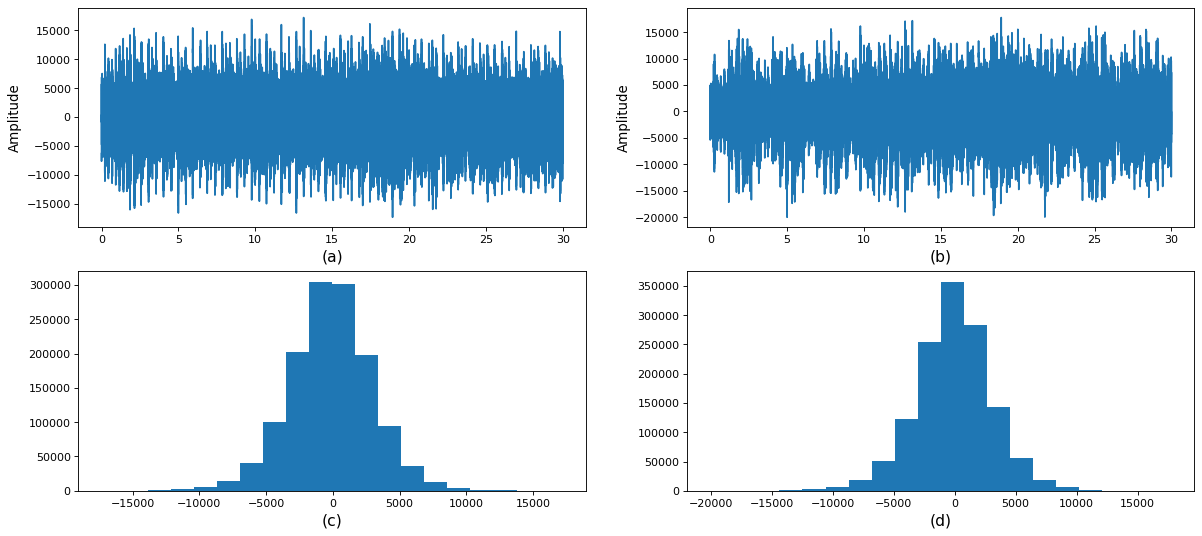

In [3]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, axs = plt.subplots(2, 2, figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
t = np.linspace(0, 30, len(signalA))
axs[0][0].plot(t, X[0, :])
axs[0][0].set_xlabel('(a)', fontsize=14)
axs[0][0].set_ylabel('Amplitude', fontsize=12)
axs[0][1].plot(t, X[1, :])
axs[0][1].set_xlabel('(b)', fontsize=14)
axs[0][1].set_ylabel('Amplitude', fontsize=12)
axs[1][0].hist(X[0, :], bins=20)
axs[1][0].set_xlabel('(c)', fontsize=14)
axs[1][1].hist(X[1, :], bins=20)
axs[1][1].set_xlabel('(d)', fontsize=14)

plt.show()

# Plot scatter diagram for source and mixed signals

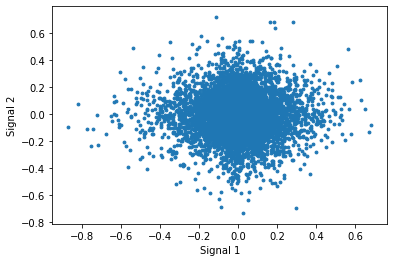

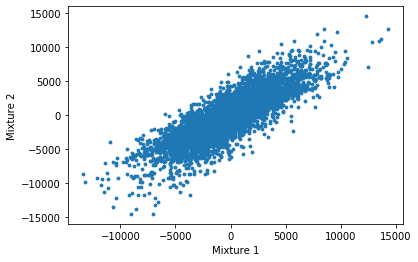

In [4]:
s=8
plt.scatter(signalA[::200], signalB[::200], s=s, marker='o')
plt.xlabel('Signal 1')
plt.ylabel('Signal 2')
plt.show()
plt.scatter(X[0, :][::200], X[1, :][::200], s=s, marker='o')
plt.xlabel('Mixture 1')
plt.ylabel('Mixture 2')
plt.show()

# Kurtuosis of source signals

In [26]:
from scipy.stats import kurtosis
print(kurtosis(signalA))
print(kurtosis(signalB))

2.2429123702486544
0.9998724775025747


# Source signals covariance

In [5]:
compute_covariance(S.T)

array([[23395237.67249921,    41115.07221397],
       [   41115.07221397, 23921130.14561763]])

# Mixture signals before and after whitening

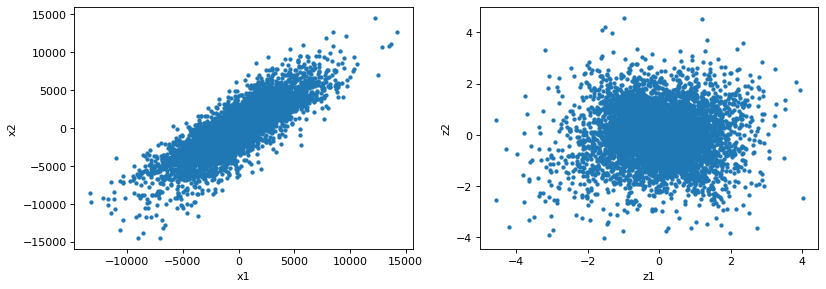

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
axs[0].scatter(X[0, :][::200], X[1, :][::200], s=s, marker='o')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[1].scatter(Xw[0, :][::200], Xw[1, :][::200], s=s, marker='o')
axs[1].set_xlabel('z1')
axs[1].set_ylabel('z2')
plt.show()

# Plot unmixed signals

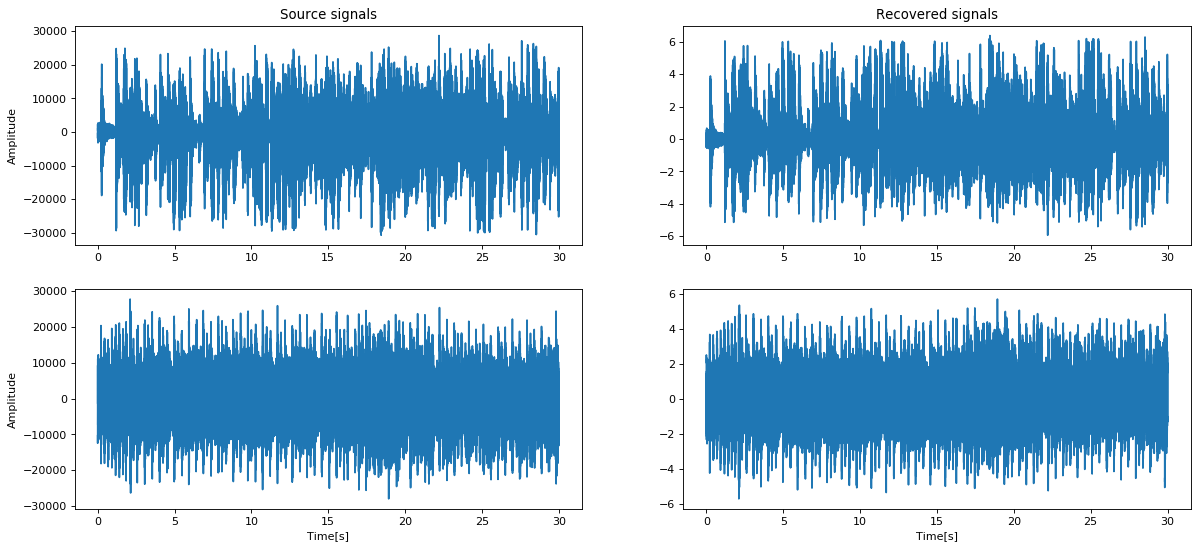

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
t = np.linspace(0, 30, len(signalA))
axs[0][0].plot(t, S[:, 0])
axs[0][0].set_ylabel('Amplitude')
axs[0][0].set_title("Source signals")
axs[1][0].plot(t, S[:, 1])
axs[1][0].set_ylabel('Amplitude')
axs[1][0].set_xlabel('Time[s]')
axs[0][1].plot(t, unMixed[:, 0])
axs[0][1].set_title("Recovered signals")
axs[1][1].plot(t, unMixed[:, 1])
axs[1][1].set_xlabel('Time[s]')

plt.show()